In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_colwidth', 400)

# Item Segmentation

In [2]:
df = pd.read_csv("data/items.csv")
df_orders = pd.read_csv("data/order_churn_data.csv")
df = df.merge(df_orders[["customer_db_id", "order_id", "order_state", "order_created_datetime", "frequency"]])
df = df.loc[df.order_state == "completed"]

In [3]:
df.customer_db_id.nunique()

33711

In [4]:
df.sort_values(["customer_db_id", "order_created_datetime"]).head()

,product_id,order_id,order_date,quantity,price_per_unit,segmentation,category,product_name,customer_db_id,order_state,order_created_datetime,frequency
276148,GB-PRO-R8877223,GB-L-58332,2017-02-12 18:56:36,20,2.2,LA,drycleaning,Men's Shirt (on hanger),545b9a8bd2cde8871f009f9b,completed,2017-02-12 17:56:36,103.625000
274729,GB-PRO-R8877223,GB-R-13286,2017-01-01 17:16:04,5,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,completed,2017-01-01 16:16:03,12.607477
275096,GB-PRO-R8877223,GB-C-99067,2017-01-13 20:23:07,5,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,completed,2017-01-13 19:23:07,12.607477
275128,GB-PRO-R8877223,GB-G-36643,2017-01-14 22:52:27,5,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,completed,2017-01-14 21:52:26,12.607477
275834,GB-PRO-R8877223,GB-X-53507,2017-02-03 18:12:38,4,2.2,LA,drycleaning,Men's Shirt (on hanger),545bf6e0d4cde8f935b78a08,completed,2017-02-03 17:12:38,12.607477


In [5]:
df.groupby('product_name')['order_id'].count().sort_values(ascending=False).head()

product_name
Men's Shirt (on hanger)        38641
Shirt (on hanger)              31858
Bag of Folded Laundry (8kg)    24049
Trousers                       21791
Suit m/f (2 piece)             13225
Name: order_id, dtype: int64

# Group Products By Type

In [6]:
df_products = pd.read_csv("data/products.csv")
unique_prods = df_products.product_name.sort_values().unique().tolist()

In [7]:
len(unique_prods)

397

In [8]:
unique_prods

['#FINILALESSIVE Blouse',
 '#FINILALESSIVE Shirt (on hanger)',
 '#LAUNDRYLIBERATION SPECIAL Blouse',
 '#LAUNDRYLIBERATION SPECIAL Shirt (on hanger)',
 '#WÄSCHEREVOLUTION Blouse',
 '#WÄSCHEREVOLUTION Shirt (on hanger)',
 "1 Suit (2 pieces), 10 Men's Shirts on a hanger & 1 Tie",
 "10 Men's Shirt (on hanger) Bundle",
 '10 Shirt (On Hanger) Bundle',
 '10 Shirts (On Hanger) Bundle',
 '10 Shirts (on hanger)',
 '10 shirts on hanger',
 '10 t-shirts',
 "11 Men's Shirt (on hanger) Bundle",
 '11 Shirts (On Hanger) Bundle',
 '11 shirts bundle',
 '12 Blouse Bundle',
 "12 Men's Shirt (on hanger) Bundle",
 '12 Shirt (On Hanger) Bundle',
 '12 Trouser Bundle',
 '12 shirts bundle',
 "13 Men's Shirt (on hanger) Bundle",
 '13 Shirt (On Hanger) Bundle',
 '13 shirts bundle',
 "14 Men's Shirt (on hanger) Bundle",
 '14 Shirt (On Hanger) Bundle',
 '14 shirts bundle',
 '15 Blouse Bundle',
 "15 Men's Shirt (on hanger) Bundle",
 '15 Shirt (On Hanger) Bundle',
 '15 Trouser Bundle',
 '15 shirts bundle',
 "16 Men's 

In [9]:
df_itemization = pd.read_csv("data/itemization.csv")
product_types = df_itemization.product_type.unique().tolist()
df_itemization.head(10)

,product_type,product_group
0,Apron,HH_others
1,Bathmat,HH_others
2,Bathrobe,HH_others
3,Bed linen Bed bundle Bedding bundle Big Bed,HH_linens
4,Bedsheets,HH_linens
5,Bedspread,HH_blanket
6,Belt,Accessories
7,Blanket,HH_blanket
8,Blazer,BUS_Blazer
9,Blouse,BUS_Blouse


## Vectorizer to identify product type

In [10]:
vectorizer = CountVectorizer(unique_prods, ngram_range=(3,5), analyzer='char')
vectorizer.fit(unique_prods)
X = vectorizer.transform(unique_prods).toarray()
y = vectorizer.transform(product_types).toarray()

In [11]:
similarities = cosine_similarity(X, y)
similarities.shape

(397, 50)

## Product Types

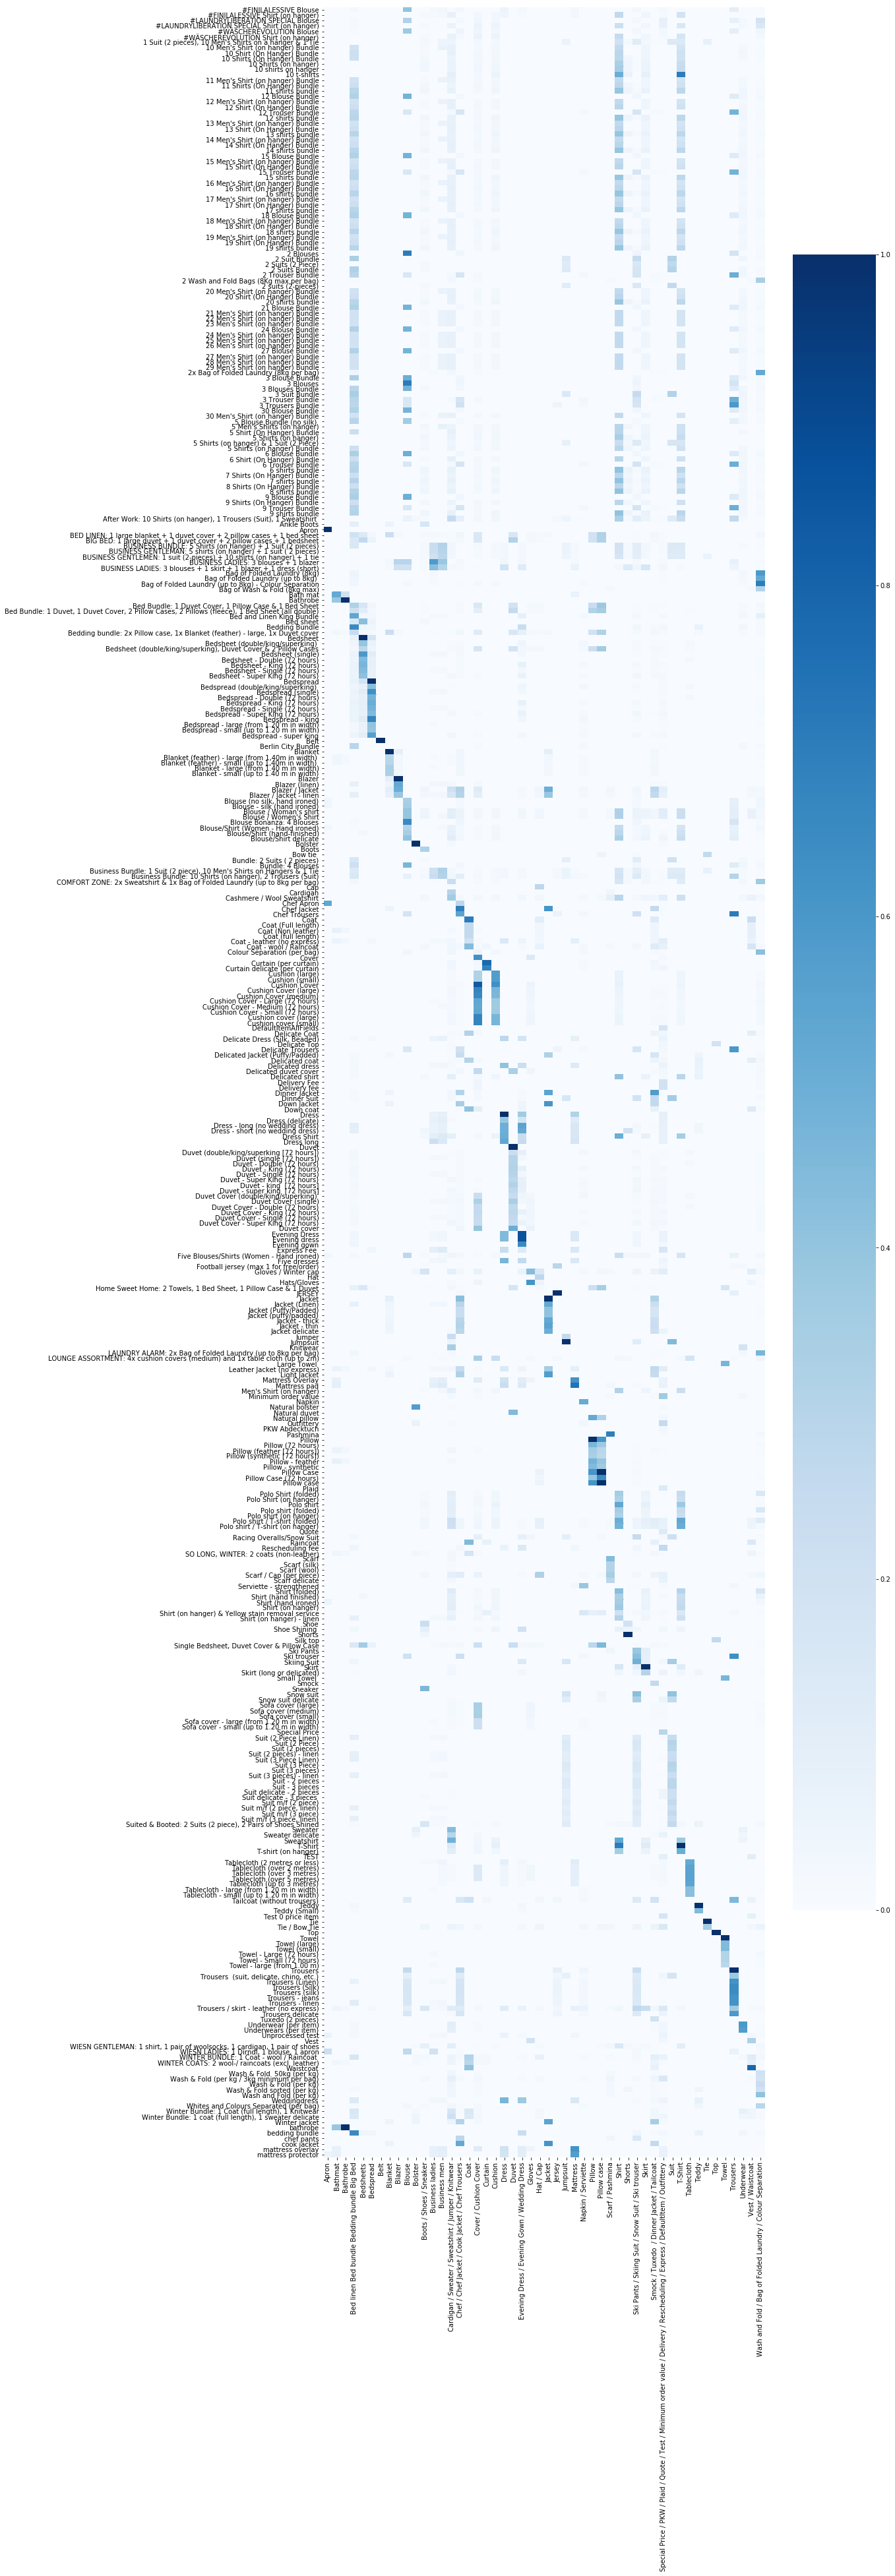

In [12]:
fig, ax = plt.subplots(figsize=(15,60))
sns.heatmap(similarities, xticklabels=product_types, yticklabels=unique_prods, cmap='Blues')

In [13]:
best_matches = similarities.argmax(axis=1)

In [14]:
df_products = pd.DataFrame(data=list(zip(unique_prods, best_matches)), columns=['product_name', 'best_match'])
df_products['product_type'] = df_products['best_match'].apply(lambda x: product_types[x])
df_products[['product_name', 'product_type']].sort_values('product_name').to_csv('data/test_products.csv', index=False)
df_products.groupby(['product_type'])['product_name'].apply(lambda x: ' | '.join(x)).reset_index()

,product_type,product_name
0,Apron,Apron | Chef Apron | Unprocessed test
1,Bathmat,Bath mat
2,Bathrobe,Bathrobe | bathrobe
3,Bed linen Bed bundle Bedding bundle Big Bed,2 Suit Bundle | 2 Suits Bundle | 3 Suit Bundle | Bed and Linen King Bundle | Bedding Bundle | Berlin City Bundle | bedding bundle
4,Bedsheets,Bed sheet | Bedsheet | Bedsheet (double/king/superking) | Bedsheet (single) | Bedsheet - Double (72 hours) | Bedsheet - King (72 hours) | Bedsheet - Single (72 hours) | Bedsheet - Super King (72 hours)
5,Bedspread,Bedspread | Bedspread (double/king/superking) | Bedspread (single) | Bedspread - Double (72 hours) | Bedspread - King (72 hours) | Bedspread - Single (72 hours) | Bedspread - Super King (72 hours) | Bedspread - king | Bedspread - large (from 1.20 m in width) | Bedspread - small (up to 1.20 m in width) | Bedspread - super king
6,Belt,Belt
7,Blanket,"Blanket | Blanket (feather) - large (from 1,40m in width) | Blanket (feather) - small (up to 1,40m in width) | Blanket - large (from 1.40 m in width) | Blanket - small (up to 1.40 m in width)"
8,Blazer,Blazer | Blazer (linen) | Blazer / Jacket | Blazer / Jacket - linen
9,Blouse,"#FINILALESSIVE Blouse | #LAUNDRYLIBERATION SPECIAL Blouse | #WÄSCHEREVOLUTION Blouse | 12 Blouse Bundle | 15 Blouse Bundle | 18 Blouse Bundle | 2 Blouses | 21 Blouse Bundle | 24 Blouse Bundle | 27 Blouse Bundle | 3 Blouse Bundle | 3 Blouses | 3 Blouses Bundle | 30 Blouse Bundle | 5 Blouse Bundle (no silk) | 6 Blouse Bundle | 9 Blouse Bundle | Blouse (no silk, hand ironed) | Blouse - silk (han..."


In [15]:
df_products = df_products.merge(df_itemization, on='product_type')

# Get Customer Product Types

In [16]:
df = df.merge(df_products, how='left', on='product_name')

In [17]:
df_cust = df.groupby(['customer_db_id', 'product_type']).agg({'quantity': 'sum', 'order_id': 'nunique', 'frequency': 'min'}).reset_index()
df_cust.head()

,customer_db_id,product_type,quantity,order_id,frequency
0,545b9a8bd2cde8871f009f9b,Shirt,20,1,103.625000
1,545bf6e0d4cde8f935b78a08,Bedsheets,28,28,12.607477
2,545bf6e0d4cde8f935b78a08,Bedspread,1,1,12.607477
3,545bf6e0d4cde8f935b78a08,Blazer,3,3,12.607477
4,545bf6e0d4cde8f935b78a08,Duvet,26,25,12.607477


In [18]:
df_dumm = pd.get_dummies(df_cust.set_index('customer_db_id')['product_type']).reset_index().groupby(['customer_db_id']).max()
df_dumm.head()

,Apron,Bathmat,Bathrobe,Bedsheets,Bedspread,Belt,Blanket,Blazer,Blouse,Bolster,...,T-Shirt,Tablecloth,Teddy,Tie,Top,Towel,Trousers,Underwear,Vest / Waistcoat,Wash and Fold / Bag of Folded Laundry / Colour Separation
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545b9a8bd2cde8871f009f9b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545bf6e0d4cde8f935b78a08,0,0,0,1,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
545e000cd4cde8f150245542,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,1,0,1,0,0,0
5460b54cd3cde8e8394e5f76,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
5460ed12d2cde8b8733e41c1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Cluster Customer based on Product Types

In [19]:
X = df_dumm.values

In [20]:
m_km = KMeans(n_clusters=10)
m_km.fit(X)
m_clusters = m_km.labels_.tolist()

In [21]:
df_clustered = df_dumm.copy()
df_clustered['cluster'] = m_clusters

## Number of customers per cluster

In [22]:
df_clustered.groupby(['cluster'])['Shirt'].count()

cluster
0    1745
1    6765
2    4597
3    2874
4    4943
5    2003
6    2723
7    3216
8    1374
9    3471
Name: Shirt, dtype: int64

## Cluster Centers

In [23]:
centers = pd.DataFrame(data=m_km.cluster_centers_, columns=df_dumm.columns)

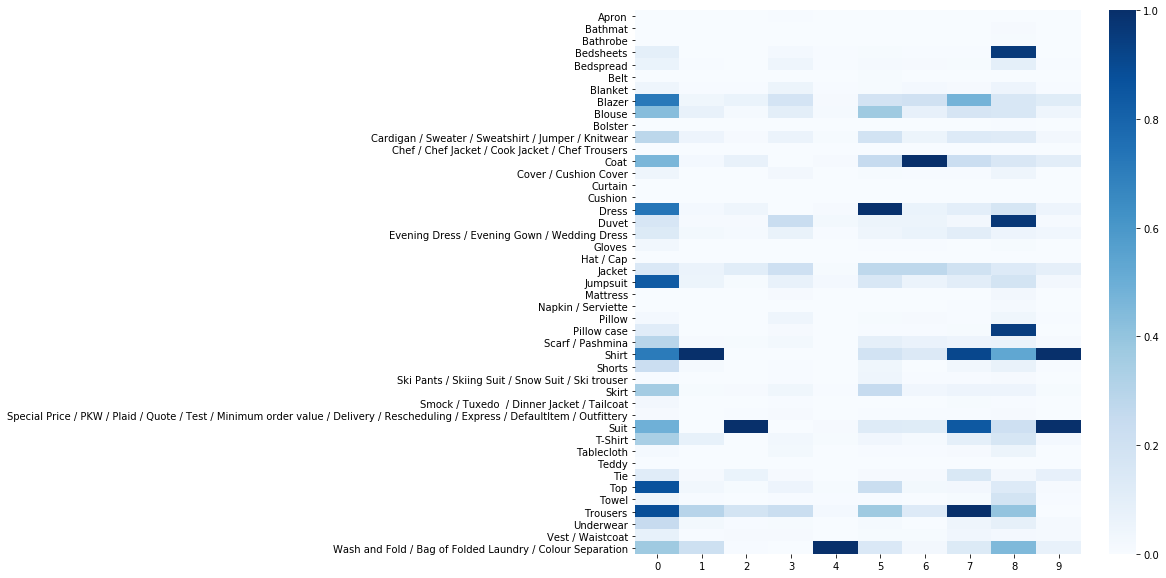

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(centers.T, cmap='Blues', yticklabels=centers.columns)

In [25]:
df_freq = df_clustered.reset_index()[['customer_db_id', 'cluster']].merge(df_cust[['customer_db_id', 'frequency']])
df_freq = df_freq.loc[df_freq.frequency > 0].drop_duplicates()

In [26]:
df_freq.groupby('cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,1619.0,50.785779,58.048168,0.360136,19.238636,33.500000,59.204762,771.0
1,3884.0,79.908616,112.722851,1.000000,21.000000,42.000000,90.750000,1325.0
2,2001.0,132.967104,142.435568,1.000000,46.000000,87.571429,161.750000,1049.0
3,719.0,167.704672,174.820277,1.000000,47.388889,114.000000,220.500000,1076.0
4,2233.0,74.894621,111.918859,1.000000,15.250000,34.000000,80.666667,1000.0
5,1199.0,96.602609,109.506905,1.000000,32.000000,63.333333,114.800000,1030.0
6,1243.0,156.482320,157.203584,1.000000,51.555556,102.000000,202.000000,1015.0
7,2886.0,65.248552,72.174316,1.666667,23.333333,42.000000,80.083333,909.0
8,1044.0,55.332446,69.081056,1.000000,18.000000,32.050000,60.723214,549.0


- 0: Wash N Fold
- 1: Shirt + Suit
- 2: Shirt, Suit, Trousers, Blazer
- 3: Shirt + Trousers
- 4: Suit
- 5: Bedsheets, Duvets, Pillow Cases
- 6: Blazer, Blouse, Dress, Top, Trousers
- 7: Coat
- 8: Shirt
- 9: Blouse, Dress, Shirt, Trousers

# Cluster Customer based on Product Groups

In [27]:
df_cust = df.groupby(['customer_db_id', 'product_group']).agg({'quantity': 'sum', 'order_id': 'nunique', 'frequency': 'min'}).reset_index()
df_dumm = pd.get_dummies(df_cust.set_index('customer_db_id')['product_group']).reset_index().groupby(['customer_db_id']).max()
df_dumm.head()

,Accessories,BUS_Blazer,BUS_Blouse,BUS_Dress,BUS_Evening Dress,BUS_Shirt,BUS_Skirt,BUS_Suit,BUS_Trousers,CAS_Jumpsuit,...,HH_covers,HH_cushions,HH_linens,HH_others,HH_pillow_case,HH_towels,OUT_Jackets + Coats,OUT_Skiwear,Others,WashFold
customer_db_id,,,,,,,,,,,,,,,,,,,,,
545b9a8bd2cde8871f009f9b,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
545bf6e0d4cde8f935b78a08,0,1,0,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
545e000cd4cde8f150245542,1,1,1,0,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
5460b54cd3cde8e8394e5f76,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5460ed12d2cde8b8733e41c1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = df_dumm.values
m_km = KMeans(n_clusters=10)
m_km.fit(X)
m_clusters = m_km.labels_.tolist()

In [29]:
df_clustered = df_dumm.copy()
df_clustered['cluster'] = m_clusters

In [31]:
df_clustered.groupby(['cluster'])['Accessories'].count()

cluster
0    5685
1    2597
2    1353
3    5635
4    4091
5    1733
6    3524
7    2812
8    1961
9    4320
Name: Accessories, dtype: int64

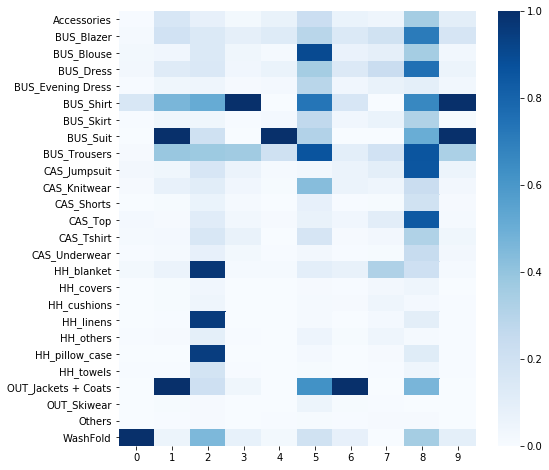

In [32]:
centers = pd.DataFrame(data=m_km.cluster_centers_, columns=df_dumm.columns)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(centers.T, cmap='Blues', yticklabels=centers.columns)

In [33]:
df_clustered = df_dumm.copy()
df_clustered['cluster'] = m_clusters

In [34]:
df_freq = df_clustered.reset_index()[['customer_db_id', 'cluster']].merge(df_cust[['customer_db_id', 'frequency']])
df_freq = df_freq.loc[df_freq.frequency > 0].drop_duplicates()

In [35]:
df_freq.groupby('cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,2642.0,73.311665,111.852346,1.000000,15.000000,33.000000,76.734375,1000.0
1,2005.0,87.885977,93.880393,1.000000,33.000000,59.833333,110.500000,1001.0
2,1017.0,56.935524,70.647111,1.000000,18.428571,33.333333,62.500000,549.0
3,3198.0,82.444537,114.623412,1.000000,22.000000,44.000000,93.150000,1325.0
4,1735.0,137.560152,146.343548,1.000000,46.000000,91.000000,170.000000,1049.0
5,1455.0,69.677909,81.816380,1.000000,24.470000,45.500000,84.666667,1015.0
6,1448.0,146.727602,153.349138,1.000000,42.000000,94.000000,194.000000,1076.0
7,744.0,166.810581,176.796922,1.000000,50.892857,110.000000,217.250000,1030.0
8,1785.0,54.007602,61.785548,0.360136,19.250000,34.500000,63.000000,583.0
